In [1]:
import numpy as np
import tensorflow as tf
import keras

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm
from transformers import AdamWeightDecay
from transformers import AutoTokenizer
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from datasets import load_dataset

from rouge import Rouge

from tensorflow.keras.callbacks import TensorBoard
from tensorboard import notebook

from tqdm.auto import tqdm

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
dataset_T5Med = load_dataset('cnn_dailymail', '3.0.0', split='train[:15%]')
dataset_test = load_dataset('cnn_dailymail', '3.0.0', split='test[0:100]')

In [3]:
dataset_T5Med = dataset_T5Med.train_test_split(test_size=0.2)

In [4]:
dataset_T5Med

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 34453
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 8614
    })
})

In [13]:
batch_size = 8
learning_rate = 4e-6
weight_decay = 0.01
epochs = 10

In [6]:
def train_validate_dataset(model, tokenized_ds, data_collator, batch_size=batch_size):
    train_dataset = model.prepare_tf_dataset(
        tokenized_ds["train"],
        batch_size=batch_size,
        shuffle=True,
        collate_fn=data_collator,
    )

    validation_dataset = model.prepare_tf_dataset(
        tokenized_ds["test"],
        batch_size=batch_size,
        shuffle=False,
        collate_fn=data_collator,
    )
    return train_dataset, validation_dataset

In [7]:
tokenizerT5Medium = AutoTokenizer.from_pretrained('t5-base', model_max_length=512)

In [8]:
max_input_length = 512
max_target_length = 128

def preprocess_function_T5Medium(examples):
    with tf.device("CPU"):
        inputs = ["summarize: " + doc for doc in examples["article"]]
        model_inputs = tokenizerT5Medium(inputs, max_length=max_input_length, truncation=True)

        # Target
        targets = tokenizerT5Medium(examples["highlights"], max_length=max_target_length, truncation=True)

        model_inputs["labels"] = targets["input_ids"]
        return model_inputs

In [9]:
tokenized_ds_T5Medium = dataset_T5Med.map(preprocess_function_T5Medium, batched=True)

Map:   0%|          | 0/34453 [00:00<?, ? examples/s]

Map:   0%|          | 0/8614 [00:00<?, ? examples/s]

In [10]:
modelT5Medium = TFAutoModelForSeq2SeqLM.from_pretrained('t5-base')

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [11]:
data_collator_T5Medium = DataCollatorForSeq2Seq(tokenizerT5Medium, model=modelT5Medium, return_tensors="np")

In [12]:
train_dataset_T5Medium, validation_dataset_T5Medium = train_validate_dataset(modelT5Medium, tokenized_ds_T5Medium, 
                                                                             data_collator_T5Medium)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [14]:
optimizer = AdamWeightDecay(learning_rate=learning_rate, weight_decay_rate=weight_decay)
modelT5Medium.compile(optimizer=optimizer,
                     metrics=['accuracy'])

In [15]:
history = modelT5Medium.fit(
            train_dataset_T5Medium, validation_data=validation_dataset_T5Medium, 
            epochs=epochs, callbacks=callbacks, batch_size=batch_size
          )

Epoch 1/10
4306/4306 [==============================] - 1714s 393ms/step - loss: 1.6408 - accuracy: 0.4965 - val_loss: 1.3946 - val_accuracy: 0.5262
Epoch 2/10
4306/4306 [==============================] - 1690s 392ms/step - loss: 1.5921 - accuracy: 0.5002 - val_loss: 1.3832 - val_accuracy: 0.5276
Epoch 3/10
4306/4306 [==============================] - 1690s 393ms/step - loss: 1.5744 - accuracy: 0.5024 - val_loss: 1.3787 - val_accuracy: 0.5283
Epoch 4/10
4306/4306 [==============================] - 1690s 392ms/step - loss: 1.5600 - accuracy: 0.5041 - val_loss: 1.3746 - val_accuracy: 0.5288
Epoch 5/10
4306/4306 [==============================] - 1691s 393ms/step - loss: 1.5493 - accuracy: 0.5056 - val_loss: 1.3717 - val_accuracy: 0.5292
Epoch 6/10
4306/4306 [==============================] - 1690s 393ms/step - loss: 1.5391 - accuracy: 0.5066 - val_loss: 1.3701 - val_accuracy: 0.5294
Epoch 7/10
4306/4306 [==============================] - 1690s 393ms/step - loss: 1.5286 - accuracy: 0.5083

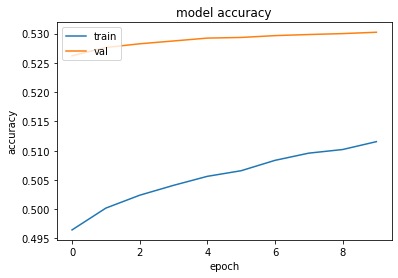

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

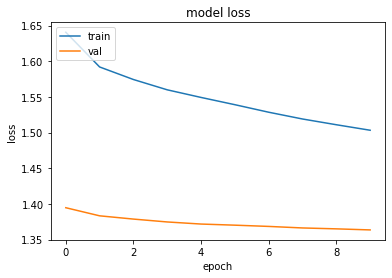

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def generate_preds(tokenizer, model):
    evaluate = []
    for element in dataset_test['article']:
        tokenized = tokenizer([element], return_tensors='np')
        pred = model.generate(**tokenized, max_length=128)
        pred = pred.numpy()
        with tf.device("CPU"):
            evaluate.append(pred)
    pred = []
    for article in evaluate:
        new_article = tokenizer.decode(article[0], skip_special_tokens=True)
        with tf.device("CPU"):
            pred.append(new_article)
    return pred

In [ ]:
def actual_preds(dataset):
    actual = []
    for summary in dataset['highlights']:
        with tf.device("CPU"):
            actual.append(summary)
    return actual

In [ ]:
pred_T5Medium = generate_preds(tokenizerT5Medium, modelT5Medium)

Token indices sequence length is longer than the specified maximum sequence length for this model (787 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
actual_T5Medium = actual_preds(dataset_test)

In [ ]:
def get_rouge_scores(actual_summary, predicted_summary):
    rouge = Rouge()
    try: 
        if (len(actual_summary) == len(predicted_summary)):
            pass
    except Exception as e:
        print(f"lengths of actual and predictions don't match: {e}")
    score_total1 = 0
    score_total2 = 0
    score_totalL = 0
    for i in range(0, len(actual_summary)):
        scores = rouge.get_scores(predicted_summary[i], actual_summary[i])
        
        score_total1 += scores[0]['rouge-1']['f']
        score_total2 += scores[0]['rouge-2']['f']
        score_totalL += scores[0]['rouge-l']['f']
    return score_total1 / len(actual_summary), score_total2 / len(actual_summary), score_totalL / len(actual_summary)

In [ ]:
rouge1T5Medium, rouge2T5Medium, rougelT5Medium = get_rouge_scores(actual_T5Medium,pred_T5Medium)

In [25]:
print(round(rouge1T5Medium, 4), round(rouge2T5Medium, 4), round(rougelT5Medium, 4))

0.3094 0.114 0.2919
